In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Dense, Dropout,LeakyReLU, Conv2DTranspose, Conv2D, Flatten, BatchNormalization
from tensorflow.keras import Model,Sequential
from tensorflow.keras.datasets import mnist
import time
from IPython import display

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)
print(train_images.shape)

(60000, 28, 28, 1)


In [13]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(7*7*256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((7, 7, 256)))    
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))
    return generator
    
g=create_generator()
g.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)        

In [14]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))   
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    return discriminator
    
d =create_discriminator()
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [28]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    final_loss = real_loss + fake_loss
    return final_loss
  
def G_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [18]:
G_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
D_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [19]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 1

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [62]:
generator = create_generator()
discriminator = create_discriminator()

g_loss = []
d_loss = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
        g_loss.append(gen_loss)
        d_loss.append(disc_loss)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [63]:
def generate_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='grey')

In [64]:
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        if epoch % 10 == 0:
            generate_images(generator,epoch + 1,seed)
        print ('에포크 {} 은/는 {} 초'.format(epoch + 1, time.time()-start))
    generate_images(generator,epochs,seed)

에포크 1 은/는 4.860841512680054 초
에포크 2 은/는 2.8020200729370117 초
에포크 3 은/는 2.820833921432495 초
에포크 4 은/는 2.8564624786376953 초
에포크 5 은/는 3.0294530391693115 초
에포크 6 은/는 2.926011085510254 초
에포크 7 은/는 2.8566224575042725 초
에포크 8 은/는 2.90209698677063 초
에포크 9 은/는 2.867588996887207 초
에포크 10 은/는 2.87892484664917 초
에포크 11 은/는 2.968341827392578 초
에포크 12 은/는 2.8764092922210693 초
에포크 13 은/는 2.8560643196105957 초
에포크 14 은/는 2.8068530559539795 초
에포크 15 은/는 2.8464505672454834 초
에포크 16 은/는 2.9154441356658936 초
에포크 17 은/는 2.9041800498962402 초
에포크 18 은/는 2.867741823196411 초
에포크 19 은/는 2.957479238510132 초
에포크 20 은/는 2.9995861053466797 초
에포크 21 은/는 3.4780397415161133 초
에포크 22 은/는 2.9047417640686035 초
에포크 23 은/는 2.956882953643799 초
에포크 24 은/는 3.0820465087890625 초
에포크 25 은/는 3.220940113067627 초
에포크 26 은/는 3.322114944458008 초
에포크 27 은/는 3.5220067501068115 초
에포크 28 은/는 3.505742073059082 초
에포크 29 은/는 3.5146093368530273 초
에포크 30 은/는 3.106318950653076 초


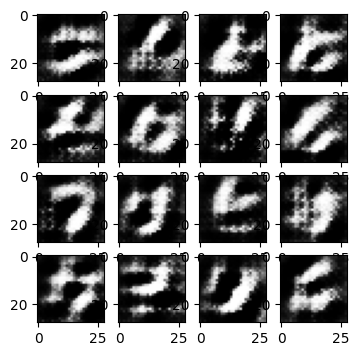

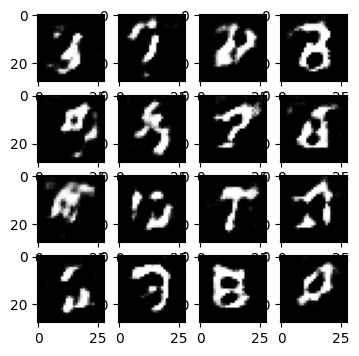

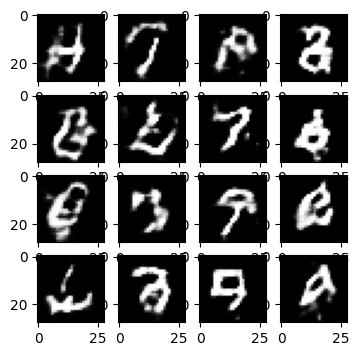

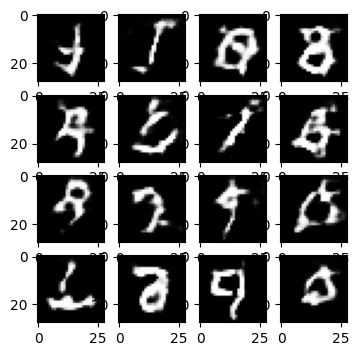

In [65]:
train_GAN(train_dataset, 30)